## Importing Libraries

In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd
import random
import time
from datetime import timedelta
from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


/media/research/BERT/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Libraries and Modules:
- `torch`: PyTorch library for deep learning.
- `transformers`: Hugging Face Transformers library for BERT models.
- `BertTokenizer`, `BertForSequenceClassification`: BERT-specific tokenizer and sequence classification model.
- `CrossEntropyLoss`: Cross-entropy loss function from PyTorch.
- `DataLoader`, `RandomSampler`, `SequentialSampler`, `TensorDataset`, `random_split`: PyTorch utilities for dataset handling.
- `AdamW`, `get_linear_schedule_with_warmup`: AdamW optimizer and a linear learning rate scheduler.
- `numpy`, `pandas`: Numerical and data manipulation libraries.
- `accuracy_score`: Function from scikit-learn to calculate accuracy.
- `tqdm`: Library for displaying progress bars.
- `random`, `time`: Randomization and time-related functionalities.

## Preparing the Dataset

In [2]:
def tokenize_dataset(dataset, tokenizer, max_len=512):
    """
    Tokenizes the input dataset using BERT's tokenizer.
    Each abstract is truncated or padded to 'max_len'.
    Returns tokenized inputs along with attention masks.
    """
    input_ids = []
    attention_masks = []

    for abstract in dataset["['abstract']"]:
        encoded_dict = tokenizer.encode_plus(
            abstract,
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=max_len,      # Pad & truncate all sentences.
            truncation=True,         # Explicitly truncate to max length
            padding='max_length',    # Pad to max_length
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors='pt',     # Return pytorch tensors.
        )
        input_ids.append(encoded_dict['input_ids'][0])
        attention_masks.append(encoded_dict['attention_mask'][0])

    input_ids = torch.stack(input_ids, dim=0)
    attention_masks = torch.stack(attention_masks, dim=0)
    labels = torch.tensor(dataset['label'].values)

    return input_ids, attention_masks, labels

# Load the dataset
df = pd.read_csv('output_file.csv')  # Use the output file from your preprocessing step
df['label'] = df['category'].map({'Physics': 0, 'Medicine': 1, 'Cybersecurity': 2})  # Convert labels to numeric

print("Total number of abstracts in the dataset:", df.shape[0])


# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize dataset
input_ids, attention_masks, labels = tokenize_dataset(df, tokenizer)

Total number of abstracts in the dataset: 1185


In [3]:
# Convert tensors to lists for saving in CSV
input_ids_list = input_ids.numpy().tolist()
attention_masks_list = attention_masks.numpy().tolist()
labels_list = labels.numpy().tolist()

# Create a new DataFrame for saving to CSV
tokenized_data = pd.DataFrame({
    'input_ids': input_ids_list,
    'attention_masks': attention_masks_list,
    'labels': labels_list
})

# Save the DataFrame to a new CSV file
tokenized_data.to_csv('tokenized_dataset.csv', index=False)

print("Tokenized dataset saved to 'tokenized_dataset.csv'")


Tokenized dataset saved to 'tokenized_dataset.csv'


#### Cell Explanation:
#### Function: `tokenize_dataset`

- **Parameters:**
  - `dataset`: Input dataset containing abstracts and labels.
  - `tokenizer`: BERT tokenizer used for tokenization.
  - `max_len`: Maximum length for abstracts, specifying truncation or padding.

- **Functionality:**
  - Tokenizes the input dataset using BERT's tokenizer.
  - Truncates or pads each abstract to the specified `max_len`.
  - Returns tokenized inputs (input_ids), attention masks, and labels.

#### Data Loading and Preprocessing:

- **Loading Dataset:**
  - Reads a CSV file ('output_file.csv') containing preprocessed data into a DataFrame (`df`).
  - Assumes the DataFrame contains a column named "['abstract']" for abstracts.

- **Label Mapping:**
  - Maps categorical labels ('Physics', 'Medicine', 'Cybersecurity') to numeric values (0, 1, 2).
  - Creates a new column "label" in the DataFrame (`df`) for the numeric labels.

#### Tokenization and Data Preparation:

- **Tokenizer Initialization:**
  - Initializes the BERT tokenizer (`tokenizer`) from 'bert-base-uncased' with lowercase option.

- **Tokenization:**
  - Calls the `tokenize_dataset` function to tokenize the entire dataset.
  - Obtains tokenized inputs (`input_ids`), attention masks, and labels.

- **Conversion to Lists:**
  - Converts tensors to lists for saving in CSV.

#### DataFrame Creation and Saving:

- **DataFrame Creation:**
  - Creates a new DataFrame (`tokenized_data`) with columns 'input_ids', 'attention_masks', and 'labels'.
  - Uses lists (`input_ids_list`, `attention_masks_list`, `labels_list`) obtained from tensor conversion.

- **CSV File Saving:**
  - Saves the tokenized DataFrame to a new CSV file ('tokenized_dataset.csv').
  - The `index=False` parameter avoids saving the DataFrame index.

#### Output Message:

- Prints a message indicating the successful saving of the tokenized dataset to 'tokenized_dataset.csv'.

## Loading the Pre-trained BERT Model

In [4]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # Use the 12-layer BERT model, with an uncased vocab.
    num_labels=3,  # The number of output labels--3 for your classification task.
    output_attentions=False,  # Whether the model returns attentions weights.
    output_hidden_states=False,  # Whether the model returns all hidden-states.
)

print("Model loaded successfully.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully.


#### Cell Explanation:
- The `BertForSequenceClassification` model is a pre-trained BERT model with an additional classification layer on top.
- It is configured for a specific classification task with three output labels ('Physics', 'Medicine', 'Cybersecurity').
- The model is loaded with the weights from the 'bert-base-uncased' pre-trained model.
#### Model Loading:

- **Model Initialization:**
  - Initializes a BERT-based sequence classification model (`model`) using `BertForSequenceClassification.from_pretrained()`.

- **Model Configuration:**
  - `from_pretrained`: Loads the 'bert-base-uncased' pretrained weights.
  - `num_labels`: Specifies the number of output labels (3 for the given classification task).
  - `output_attentions`: Determines whether the model returns attention weights (set to False).
  - `output_hidden_states`: Determines whether the model returns all hidden states (set to False).

- **Output Message:**
  - Prints a message indicating the successful loading of the model.

## Training Loop

### Preparation

In [5]:
# Check if GPU is available and use it; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Send the model to the device (GPU or CPU)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

#### Cell Explanation:
#### Device Setup:
- `device`: Checks GPU availability and sends the model to GPU if available; otherwise, uses CPU.

### Main Training Loop

In [6]:
# Seed for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Freeze only the lower layers of the BERT model
num_layers = len(model.bert.encoder.layer)
for i in range(0, num_layers//2):  # Freezing the lower half of the layers
    for param in model.bert.encoder.layer[i].parameters():
        param.requires_grad = False

# Initializing lists to store metrics for all folds
all_folds_train_losses = []
all_folds_val_losses = []
all_folds_train_accuracies = []
all_folds_val_accuracies = []

# Prepare for K-Fold Cross-Validation
n_splits = 5
batch_size = 32
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_val)
loss_function = CrossEntropyLoss()

# Before starting the K-Fold Cross-Validation
all_true_labels = []
all_predictions = []

# K-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(skf.split(input_ids, labels.numpy())):
    print(f'\n======== Fold {fold + 1} / {n_splits} ========')

    # Lists to store metrics for the current fold
    fold_train_losses = []
    fold_val_losses = []
    fold_train_accuracies = []
    fold_val_accuracies = []
    fold_predictions = []
    fold_true_labels = []
    
    # Create training and validation subsets for the current fold
    train_subset = TensorDataset(input_ids[train_idx], attention_masks[train_idx], labels[train_idx])
    val_subset = TensorDataset(input_ids[val_idx], attention_masks[val_idx], labels[val_idx])

    # Create dataloaders for training and validation subsets
    train_dataloader = DataLoader(train_subset, sampler=RandomSampler(train_subset), batch_size=batch_size)
    validation_dataloader = DataLoader(val_subset, sampler=SequentialSampler(val_subset), batch_size=batch_size)

    # AdamW is a class from the huggingface library
    optimizer = AdamW(model.parameters(),
                      lr=5e-5,  # Learning rate
                      eps=1e-8  # Epsilon to prevent division by zero in optimizer updates
    )

    # Number of training epochs (can be tuned based on your dataset size and model complexity)
    epochs = 4

    # Total number of training steps is the number of batches per epoch times the number of epochs
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler to decrease the learning rate as training progresses
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,  # No warmup steps
                                            num_training_steps=total_steps)

    print("Optimizer and scheduler set up successfully.")
        
    # Training Loop
    for epoch_i in range(0, epochs):
        print(f'\nEpoch {epoch_i + 1} / {epochs}')
        print('Training...')
        start_time_epoch = time.time()

        total_train_loss = 0
        total_train_accuracy = 0
        model.train()

        for batch in tqdm(train_dataloader, desc='Training', leave=False):
            start_time_batch = time.time()

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            # Calculate batch accuracy
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).flatten()
            batch_accuracy = (preds == b_labels).cpu().numpy().mean()
            total_train_accuracy += batch_accuracy

            elapsed_time_batch = str(timedelta(seconds=int(round(time.time() - start_time_batch))))
            print(f"Batch Loss: {loss.item():.4f}, Time: {elapsed_time_batch}", end='\r')

        elapsed_time_epoch = str(timedelta(seconds=int(round(time.time() - start_time_epoch))))
        avg_train_loss = total_train_loss / len(train_dataloader)
        fold_train_losses.append(avg_train_loss)
        train_accuracy_for_this_epoch = total_train_accuracy / len(train_dataloader)
        fold_train_accuracies.append(train_accuracy_for_this_epoch)
        print(f"\nAverage training loss: {avg_train_loss:.2f} | Epoch Time: {elapsed_time_epoch}")
        print(f"\nTraining Accuracy for this Epoch: {train_accuracy_for_this_epoch:.2f} | Epoch Time: {elapsed_time_epoch}")

        # Validation Loop
        print('\nValidation...')
        start_time_epoch = time.time()
        model.eval()
        total_eval_loss = 0
        total_eval_accuracy = 0
        nb_eval_steps = 0  # Count the number of validation steps (batches)

        for batch in tqdm(validation_dataloader, desc='Validation', leave=False):
            start_time_batch = time.time()

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                logits = outputs.logits
                # Compute validation loss
                loss = loss_function(logits, b_labels)
                total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # label_ids = b_labels.to('cuda').numpy()
            
            # Calculate and accumulate batch accuracy
            tmp_eval_accuracy = accuracy_score(label_ids, np.argmax(logits, axis=1).flatten())
            total_eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1  # Increment the count of validation steps

            elapsed_time_batch = str(timedelta(seconds=int(round(time.time() - start_time_batch))))
            print(f"Batch Loss: {loss.item():.4f}, Time: {elapsed_time_batch}", end='\r')

        elapsed_time_epoch = str(timedelta(seconds=int(round(time.time() - start_time_epoch))))
        # Calculate the average validation loss and accuracy for the epoch
        avg_val_loss = total_eval_loss / nb_eval_steps
        avg_val_accuracy = total_eval_accuracy / nb_eval_steps
        fold_val_losses.append(avg_val_loss)
        fold_val_accuracies.append(avg_val_accuracy)

        print(f"\nAverage Validation Loss: {avg_val_loss:.2f} | Epoch Time: {str(timedelta(seconds=int(round(time.time() - start_time_epoch))))}")
        print(f"\nValidation Accuracy for this Epoch: {avg_val_accuracy:.2f} | Epoch Time: {str(timedelta(seconds=int(round(time.time() - start_time_epoch))))}")
        
    # Accumulate predictions and true labels only after the final epoch of the fold
    if epoch_i == epochs - 1:
        print('\nCollecting predictions and labels from the final epoch of the fold...')
        for batch in tqdm(validation_dataloader, desc='Final Epoch Validation', leave=False):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            batch_predictions = np.argmax(logits, axis=1)
            all_predictions.extend(batch_predictions)
            all_true_labels.extend(label_ids)  
            
    # After the last epoch of the fold, calculate and print the confusion matrix
    if epoch_i == epochs - 1:
        print('\nCalculating confusion matrix for the final epoch of the fold...')

        # Ensure model is in evaluation mode
        model.eval()

        # Iterate over the validation data
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            batch_predictions = np.argmax(logits, axis=1)
            fold_predictions.extend(batch_predictions)
            fold_true_labels.extend(label_ids)

        # Calculate the confusion matrix for this fold
        cm = confusion_matrix(fold_true_labels, fold_predictions)
        print(f"\nConfusion Matrix for Fold {fold + 1}:")
        print(cm)       
        
        # Append fold metrics to overall lists
        all_folds_train_losses.append(fold_train_losses)
        all_folds_val_losses.append(fold_val_losses)
        all_folds_train_accuracies.append(fold_train_accuracies)
        all_folds_val_accuracies.append(fold_val_accuracies)
        

print("\nK-Fold Cross-validation complete!")

/media/research/BERT/env/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Fold 1 / 5 ========
Optimizer and scheduler set up successfully.

Epoch 1 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:02<01:25,  2.95s/it]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:03<00:51,  1.83s/it]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:04<00:37,  1.40s/it]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:06<00:36,  1.40s/it]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:07<00:32,  1.30s/it]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:07<00:24,  1.03s/it]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:08<00:19,  1.17it/s]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:09<00:20,  1.09it/s]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:10<00:21,  1.05s/it]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:11<00:21,  1.08s/it]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:13<00:21,  1.15s/it]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:13<00:18,  1.02s/it]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:15<00:19,  1.16s/it]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:16<00:18,  1.14s/it]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:17<00:14,  1.05it/s]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:17<00:11,  1.23it/s]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:19<00:13,  1.05s/it]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:20<00:11,  1.01it/s]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:21<00:11,  1.01s/it]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:22<00:10,  1.08s/it]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:23<00:09,  1.06s/it]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:24<00:09,  1.21s/it]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:25<00:07,  1.12s/it]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:26<00:05,  1.07it/s]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:26<00:04,  1.24it/s]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:28<00:04,  1.05s/it]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:29<00:03,  1.00s/it]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:30<00:02,  1.13s/it]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:31<00:01,  1.07s/it]

Batch Loss: 0.4955, Time: 0:00:01
Average training loss: 0.85 | Epoch Time: 0:00:32

Training Accuracy for this Epoch: 0.65 | Epoch Time: 0:00:32

Validation...


Validation:  12%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                | 1/8 [00:00<00:03,  1.84it/s]

Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:01<00:03,  2.00it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:01<00:02,  1.85it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:02<00:02,  1.85it/s]

Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/8 [00:02<00:00,  2.33it/s]

Batch Loss: 0.6677, Time: 0:00:00
Average Validation Loss: 0.49 | Epoch Time: 0:00:03

Validation Accuracy for this Epoch: 0.89 | Epoch Time: 0:00:03

Epoch 2 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:00<00:14,  1.99it/s]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:01<00:22,  1.25it/s]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:02<00:27,  1.02s/it]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:03<00:22,  1.14it/s]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:05<00:28,  1.15s/it]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:06<00:25,  1.07s/it]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:07<00:27,  1.19s/it]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:08<00:25,  1.14s/it]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:08<00:19,  1.06it/s]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:09<00:16,  1.24it/s]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:10<00:16,  1.14it/s]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:11<00:17,  1.00it/s]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:12<00:17,  1.03s/it]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:14<00:17,  1.07s/it]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:14<00:14,  1.04it/s]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:16<00:15,  1.13s/it]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:17<00:14,  1.10s/it]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:17<00:11,  1.09it/s]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:18<00:08,  1.26it/s]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:19<00:10,  1.03s/it]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:20<00:08,  1.02it/s]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:21<00:08,  1.04s/it]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:23<00:07,  1.14s/it]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:24<00:06,  1.12s/it]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:25<00:06,  1.20s/it]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:26<00:04,  1.12s/it]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:27<00:02,  1.07it/s]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:27<00:01,  1.24it/s]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:29<00:00,  1.02it/s]

Batch Loss: 0.1321, Time: 0:00:01
Average training loss: 0.31 | Epoch Time: 0:00:30

Training Accuracy for this Epoch: 0.91 | Epoch Time: 0:00:30

Validation...


Validation:  12%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                | 1/8 [00:00<00:01,  5.20it/s]

Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:00<00:02,  2.59it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:01<00:02,  2.17it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:01<00:01,  2.07it/s]

Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/8 [00:02<00:00,  2.58it/s]

Batch Loss: 0.3225, Time: 0:00:00
Average Validation Loss: 0.21 | Epoch Time: 0:00:03

Validation Accuracy for this Epoch: 0.94 | Epoch Time: 0:00:03

Epoch 3 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:01<00:42,  1.45s/it]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:03<00:42,  1.53s/it]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:03<00:28,  1.06s/it]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:04<00:21,  1.19it/s]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:05<00:23,  1.07it/s]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:06<00:26,  1.08s/it]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:07<00:21,  1.06it/s]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:08<00:25,  1.17s/it]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:09<00:20,  1.04it/s]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:10<00:21,  1.09s/it]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:12<00:22,  1.18s/it]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:12<00:17,  1.03it/s]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:13<00:14,  1.20it/s]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:13<00:13,  1.20it/s]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:15<00:13,  1.08it/s]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:15<00:12,  1.15it/s]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:17<00:13,  1.07s/it]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:18<00:12,  1.02s/it]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:19<00:12,  1.16s/it]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:20<00:11,  1.13s/it]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:21<00:08,  1.06it/s]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:21<00:06,  1.24it/s]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:22<00:06,  1.09it/s]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:24<00:06,  1.01s/it]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:25<00:05,  1.12s/it]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:26<00:04,  1.12s/it]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:27<00:03,  1.03s/it]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:28<00:02,  1.15s/it]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:30<00:01,  1.18s/it]

Batch Loss: 0.3409, Time: 0:00:00
Average training loss: 0.17 | Epoch Time: 0:00:31

Training Accuracy for this Epoch: 0.96 | Epoch Time: 0:00:31

Validation...


Validation:  12%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                | 1/8 [00:00<00:01,  5.17it/s]

Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:00<00:01,  5.16it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:00<00:00,  5.14it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:00<00:00,  5.11it/s]

Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5/8 [00:01<00:00,  3.18it/s]

Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/8 [00:01<00:00,  2.58it/s]

Batch Loss: 0.3692, Time: 0:00:00
Average Validation Loss: 0.21 | Epoch Time: 0:00:03

Validation Accuracy for this Epoch: 0.93 | Epoch Time: 0:00:03

Epoch 4 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:00<00:27,  1.04it/s]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:02<00:35,  1.27s/it]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:02<00:25,  1.07it/s]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:04<00:31,  1.20s/it]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:05<00:31,  1.25s/it]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:06<00:23,  1.01it/s]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:06<00:19,  1.20it/s]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:08<00:21,  1.03it/s]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:09<00:20,  1.02it/s]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:09<00:17,  1.13it/s]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:11<00:20,  1.07s/it]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:12<00:18,  1.01s/it]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:13<00:19,  1.13s/it]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:14<00:18,  1.16s/it]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:15<00:14,  1.04it/s]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:15<00:11,  1.21it/s]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:17<00:12,  1.01it/s]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:18<00:12,  1.06s/it]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:19<00:11,  1.06s/it]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:20<00:11,  1.10s/it]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:22<00:10,  1.16s/it]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:23<00:10,  1.30s/it]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:24<00:08,  1.18s/it]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:25<00:05,  1.03it/s]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:25<00:04,  1.20it/s]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:27<00:04,  1.22s/it]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:28<00:03,  1.01s/it]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:29<00:02,  1.13s/it]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:30<00:01,  1.04s/it]

Batch Loss: 0.0279, Time: 0:00:01
Average training loss: 0.11 | Epoch Time: 0:00:31

Training Accuracy for this Epoch: 0.97 | Epoch Time: 0:00:31

Validation...


Validation:  12%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                | 1/8 [00:00<00:04,  1.69it/s]

Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:01<00:04,  1.42it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:01<00:03,  1.58it/s]

Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5/8 [00:02<00:01,  2.22it/s]

Validation:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7/8 [00:03<00:00,  3.25it/s]

Batch Loss: 0.3851, Time: 0:00:00
Average Validation Loss: 0.20 | Epoch Time: 0:00:03

Validation Accuracy for this Epoch: 0.94 | Epoch Time: 0:00:03




Calculating confusion matrix for the final epoch of the fold...


/media/research/BERT/env/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Confusion Matrix for Fold 1:
[[75  3  1]
 [ 8 71  0]
 [ 2  0 77]]

======== Fold 2 / 5 ========
Optimizer and scheduler set up successfully.

Epoch 1 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:01<00:47,  1.63s/it]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:03<00:41,  1.48s/it]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:03<00:27,  1.04s/it]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:04<00:21,  1.21it/s]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:05<00:25,  1.01s/it]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:06<00:23,  1.03it/s]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:06<00:20,  1.12it/s]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:08<00:22,  1.04s/it]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:09<00:20,  1.02it/s]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:10<00:23,  1.18s/it]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:12<00:23,  1.22s/it]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:12<00:18,  1.00s/it]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:13<00:14,  1.18it/s]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:14<00:14,  1.11it/s]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:15<00:15,  1.05s/it]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:16<00:16,  1.17s/it]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:18<00:14,  1.14s/it]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:18<00:12,  1.07s/it]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:20<00:13,  1.20s/it]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:21<00:11,  1.14s/it]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:21<00:08,  1.05it/s]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:22<00:06,  1.22it/s]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:23<00:06,  1.04it/s]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:24<00:05,  1.06it/s]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:26<00:05,  1.07s/it]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:26<00:04,  1.00s/it]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:28<00:03,  1.10s/it]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:29<00:02,  1.24s/it]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:30<00:01,  1.16s/it]

Batch Loss: 0.1075, Time: 0:00:00
Average training loss: 0.15 | Epoch Time: 0:00:31

Training Accuracy for this Epoch: 0.95 | Epoch Time: 0:00:31

Validation...


Validation:  12%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                | 1/8 [00:00<00:01,  5.19it/s]

Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:00<00:01,  5.15it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:00<00:00,  5.12it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:01<00:01,  2.68it/s]

Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5/8 [00:01<00:01,  2.08it/s]

Validation:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7/8 [00:02<00:00,  2.39it/s]

Batch Loss: 0.0103, Time: 0:00:00
Average Validation Loss: 0.11 | Epoch Time: 0:00:03

Validation Accuracy for this Epoch: 0.97 | Epoch Time: 0:00:03

Epoch 2 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:01<00:30,  1.07s/it]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:02<00:30,  1.10s/it]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:03<00:27,  1.00s/it]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:04<00:30,  1.17s/it]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:05<00:29,  1.17s/it]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:06<00:22,  1.06it/s]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:06<00:18,  1.25it/s]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:08<00:21,  1.03it/s]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:08<00:19,  1.08it/s]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:10<00:20,  1.00s/it]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:10<00:17,  1.06it/s]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:12<00:19,  1.06s/it]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:13<00:19,  1.14s/it]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:14<00:16,  1.04s/it]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:14<00:13,  1.14it/s]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:15<00:12,  1.13it/s]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:17<00:14,  1.13s/it]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:18<00:12,  1.04s/it]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:19<00:13,  1.24s/it]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:20<00:10,  1.02s/it]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:21<00:09,  1.09s/it]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:23<00:09,  1.25s/it]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:23<00:07,  1.03s/it]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:24<00:05,  1.15it/s]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:25<00:04,  1.07it/s]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:26<00:03,  1.05it/s]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:27<00:03,  1.03s/it]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:28<00:02,  1.12s/it]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:29<00:01,  1.06s/it]

Batch Loss: 0.0103, Time: 0:00:01
Average training loss: 0.08 | Epoch Time: 0:00:31

Training Accuracy for this Epoch: 0.97 | Epoch Time: 0:00:31

Validation...


Validation:  12%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                | 1/8 [00:00<00:03,  1.92it/s]

Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:01<00:03,  1.97it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:01<00:01,  2.51it/s]

Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/8 [00:02<00:00,  3.57it/s]

Batch Loss: 0.0033, Time: 0:00:00
Average Validation Loss: 0.11 | Epoch Time: 0:00:02

Validation Accuracy for this Epoch: 0.97 | Epoch Time: 0:00:02

Epoch 3 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:00<00:24,  1.19it/s]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:02<00:34,  1.24s/it]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:03<00:28,  1.07s/it]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:04<00:34,  1.34s/it]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:05<00:25,  1.04s/it]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:07<00:30,  1.29s/it]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:08<00:30,  1.32s/it]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:09<00:24,  1.13s/it]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:09<00:19,  1.07it/s]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:10<00:18,  1.09it/s]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:12<00:19,  1.05s/it]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:12<00:17,  1.03it/s]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:14<00:19,  1.17s/it]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:15<00:15,  1.03it/s]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:16<00:17,  1.15s/it]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:18<00:17,  1.25s/it]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:18<00:13,  1.03s/it]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:19<00:10,  1.15it/s]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:20<00:10,  1.08it/s]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:21<00:09,  1.05it/s]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:22<00:09,  1.03s/it]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:23<00:08,  1.02s/it]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:24<00:06,  1.04it/s]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:25<00:07,  1.19s/it]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:26<00:05,  1.14s/it]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:27<00:03,  1.06it/s]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:27<00:02,  1.23it/s]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:29<00:02,  1.07s/it]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:30<00:01,  1.03s/it]

Batch Loss: 0.0103, Time: 0:00:01
Average training loss: 0.05 | Epoch Time: 0:00:31

Training Accuracy for this Epoch: 0.99 | Epoch Time: 0:00:31

Validation...


Validation:  12%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                | 1/8 [00:00<00:04,  1.54it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:01<00:01,  2.51it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:01<00:01,  3.15it/s]

Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5/8 [00:02<00:01,  2.49it/s]

Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/8 [00:02<00:00,  2.22it/s]

Batch Loss: 0.0013, Time: 0:00:00
Average Validation Loss: 0.11 | Epoch Time: 0:00:03

Validation Accuracy for this Epoch: 0.97 | Epoch Time: 0:00:03

Epoch 4 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:01<00:45,  1.56s/it]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:02<00:26,  1.06it/s]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:02<00:20,  1.35it/s]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:03<00:25,  1.03it/s]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:05<00:26,  1.06s/it]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:06<00:27,  1.15s/it]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:07<00:26,  1.15s/it]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:08<00:23,  1.08s/it]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:10<00:25,  1.24s/it]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:11<00:24,  1.23s/it]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:11<00:19,  1.01s/it]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:12<00:15,  1.17it/s]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:13<00:16,  1.01it/s]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:14<00:14,  1.07it/s]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:16<00:17,  1.18s/it]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:17<00:15,  1.09s/it]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:18<00:15,  1.23s/it]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:20<00:16,  1.36s/it]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:20<00:12,  1.11s/it]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:21<00:09,  1.08it/s]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:22<00:08,  1.08it/s]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:23<00:08,  1.10s/it]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:24<00:07,  1.03s/it]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:25<00:06,  1.14s/it]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:26<00:05,  1.04s/it]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:28<00:04,  1.12s/it]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:29<00:03,  1.09s/it]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:29<00:01,  1.09it/s]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:30<00:00,  1.26it/s]

Batch Loss: 0.0046, Time: 0:00:01
Average training loss: 0.03 | Epoch Time: 0:00:31

Training Accuracy for this Epoch: 0.99 | Epoch Time: 0:00:31

Validation...


Validation:  12%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                | 1/8 [00:00<00:03,  1.87it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:01<00:01,  2.73it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:01<00:01,  3.34it/s]

Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5/8 [00:01<00:01,  2.63it/s]

Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/8 [00:02<00:00,  2.24it/s]

Validation:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7/8 [00:03<00:00,  2.07it/s]

Batch Loss: 0.0010, Time: 0:00:00
Average Validation Loss: 0.14 | Epoch Time: 0:00:03

Validation Accuracy for this Epoch: 0.96 | Epoch Time: 0:00:03




Calculating confusion matrix for the final epoch of the fold...


/media/research/BERT/env/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Confusion Matrix for Fold 2:
[[74  4  1]
 [ 4 75  0]
 [ 0  0 79]]

======== Fold 3 / 5 ========
Optimizer and scheduler set up successfully.

Epoch 1 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:01<00:37,  1.29s/it]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:02<00:26,  1.04it/s]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:03<00:31,  1.18s/it]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:04<00:26,  1.03s/it]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:05<00:28,  1.14s/it]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:06<00:29,  1.22s/it]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:07<00:25,  1.13s/it]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:08<00:20,  1.08it/s]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:09<00:19,  1.08it/s]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:10<00:23,  1.15s/it]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:11<00:18,  1.05it/s]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:13<00:20,  1.14s/it]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:13<00:17,  1.01s/it]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:15<00:17,  1.08s/it]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:16<00:19,  1.28s/it]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:17<00:14,  1.04s/it]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:17<00:11,  1.13it/s]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:18<00:10,  1.11it/s]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:20<00:11,  1.06s/it]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:21<00:10,  1.02s/it]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:22<00:10,  1.17s/it]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:23<00:07,  1.03it/s]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:24<00:07,  1.02s/it]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:25<00:07,  1.20s/it]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:26<00:04,  1.01it/s]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:26<00:03,  1.18it/s]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:27<00:02,  1.16it/s]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:29<00:02,  1.09s/it]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:30<00:01,  1.04s/it]

Batch Loss: 0.3643, Time: 0:00:01
Average training loss: 0.11 | Epoch Time: 0:00:31

Training Accuracy for this Epoch: 0.97 | Epoch Time: 0:00:31

Validation...


Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:00<00:01,  3.02it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:00<00:01,  3.72it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:01<00:01,  3.14it/s]

Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5/8 [00:01<00:01,  2.34it/s]

Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/8 [00:02<00:00,  2.36it/s]

Batch Loss: 0.0009, Time: 0:00:00
Average Validation Loss: 0.02 | Epoch Time: 0:00:03

Validation Accuracy for this Epoch: 1.00 | Epoch Time: 0:00:03

Epoch 2 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:01<00:33,  1.16s/it]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:01<00:21,  1.29it/s]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:02<00:17,  1.53it/s]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:03<00:23,  1.10it/s]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:04<00:21,  1.18it/s]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:05<00:25,  1.04s/it]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:06<00:23,  1.00s/it]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:07<00:23,  1.07s/it]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:09<00:24,  1.17s/it]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:10<00:21,  1.08s/it]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:10<00:17,  1.11it/s]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:11<00:16,  1.10it/s]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:13<00:20,  1.18s/it]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:13<00:15,  1.02it/s]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:15<00:17,  1.17s/it]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:16<00:14,  1.06s/it]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:17<00:14,  1.13s/it]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:19<00:15,  1.26s/it]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:19<00:12,  1.13s/it]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:20<00:09,  1.06it/s]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:21<00:08,  1.05it/s]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:23<00:09,  1.20s/it]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:23<00:07,  1.06s/it]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:25<00:07,  1.24s/it]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:26<00:05,  1.02s/it]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:27<00:04,  1.14s/it]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:28<00:03,  1.23s/it]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:29<00:02,  1.01s/it]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:29<00:00,  1.16it/s]

Batch Loss: 0.0045, Time: 0:00:01
Average training loss: 0.05 | Epoch Time: 0:00:31

Training Accuracy for this Epoch: 0.99 | Epoch Time: 0:00:31

Validation...


Validation:  12%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                | 1/8 [00:00<00:03,  2.01it/s]

Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:00<00:02,  2.07it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:01<00:01,  2.29it/s]

Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5/8 [00:02<00:01,  2.86it/s]

Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/8 [00:02<00:00,  2.35it/s]

Batch Loss: 0.0003, Time: 0:00:00
Average Validation Loss: 0.02 | Epoch Time: 0:00:04

Validation Accuracy for this Epoch: 1.00 | Epoch Time: 0:00:04

Epoch 3 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:00<00:25,  1.12it/s]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:02<00:31,  1.14s/it]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:03<00:33,  1.24s/it]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:04<00:28,  1.11s/it]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:04<00:22,  1.12it/s]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:05<00:21,  1.12it/s]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:07<00:26,  1.17s/it]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:08<00:22,  1.01s/it]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:09<00:25,  1.20s/it]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:10<00:19,  1.01it/s]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:11<00:21,  1.14s/it]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:12<00:19,  1.11s/it]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:13<00:17,  1.02s/it]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:14<00:13,  1.16it/s]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:15<00:12,  1.16it/s]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:16<00:15,  1.11s/it]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:17<00:12,  1.07it/s]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:18<00:12,  1.07s/it]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:19<00:10,  1.00it/s]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:20<00:10,  1.10s/it]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:22<00:10,  1.14s/it]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:22<00:08,  1.05s/it]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:23<00:06,  1.13it/s]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:24<00:05,  1.11it/s]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:25<00:05,  1.07s/it]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:26<00:04,  1.02s/it]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:28<00:03,  1.21s/it]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:28<00:01,  1.00it/s]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:30<00:01,  1.15s/it]

Batch Loss: 0.0027, Time: 0:00:01
Average training loss: 0.03 | Epoch Time: 0:00:31

Training Accuracy for this Epoch: 0.99 | Epoch Time: 0:00:31

Validation...


Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:00<00:02,  2.90it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:01<00:00,  4.11it/s]

Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/8 [00:01<00:00,  4.63it/s]

Batch Loss: 0.0003, Time: 0:00:00
Average Validation Loss: 0.00 | Epoch Time: 0:00:02

Validation Accuracy for this Epoch: 1.00 | Epoch Time: 0:00:02

Epoch 4 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:01<00:42,  1.47s/it]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:02<00:30,  1.10s/it]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:04<00:37,  1.40s/it]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:04<00:30,  1.18s/it]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:06<00:29,  1.17s/it]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:07<00:28,  1.19s/it]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:08<00:25,  1.11s/it]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:08<00:20,  1.09it/s]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:09<00:17,  1.17it/s]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:10<00:21,  1.06s/it]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:11<00:16,  1.13it/s]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:13<00:21,  1.19s/it]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:13<00:16,  1.02it/s]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:15<00:18,  1.18s/it]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:17<00:19,  1.29s/it]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:17<00:14,  1.05s/it]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:18<00:11,  1.12it/s]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:19<00:12,  1.04s/it]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:20<00:11,  1.05s/it]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:21<00:09,  1.02it/s]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:22<00:10,  1.15s/it]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:23<00:08,  1.07s/it]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:25<00:08,  1.20s/it]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:26<00:06,  1.10s/it]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:26<00:04,  1.09it/s]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:27<00:03,  1.25it/s]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:28<00:02,  1.10it/s]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:29<00:01,  1.01it/s]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:30<00:00,  1.01it/s]

Batch Loss: 0.0022, Time: 0:00:01
Average training loss: 0.02 | Epoch Time: 0:00:31

Training Accuracy for this Epoch: 0.99 | Epoch Time: 0:00:31

Validation...


Validation:  12%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                | 1/8 [00:00<00:01,  5.19it/s]

Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:00<00:01,  5.12it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:00<00:01,  2.84it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:01<00:01,  2.40it/s]

Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5/8 [00:01<00:01,  2.16it/s]

Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/8 [00:02<00:01,  1.76it/s]

Batch Loss: 0.0002, Time: 0:00:00
Average Validation Loss: 0.00 | Epoch Time: 0:00:03

Validation Accuracy for this Epoch: 1.00 | Epoch Time: 0:00:03




Calculating confusion matrix for the final epoch of the fold...


/media/research/BERT/env/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Confusion Matrix for Fold 3:
[[79  0  0]
 [ 0 79  0]
 [ 0  0 79]]

======== Fold 4 / 5 ========
Optimizer and scheduler set up successfully.

Epoch 1 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:00<00:14,  1.97it/s]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:02<00:32,  1.16s/it]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:03<00:37,  1.39s/it]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:04<00:27,  1.04s/it]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:04<00:21,  1.18it/s]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:05<00:19,  1.24it/s]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:07<00:24,  1.06s/it]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:08<00:22,  1.01s/it]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:09<00:25,  1.24s/it]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:10<00:20,  1.01s/it]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:11<00:22,  1.17s/it]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:13<00:23,  1.29s/it]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:13<00:17,  1.05s/it]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:14<00:14,  1.13it/s]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:15<00:13,  1.08it/s]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:16<00:14,  1.05s/it]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:17<00:14,  1.12s/it]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:19<00:13,  1.13s/it]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:19<00:11,  1.03s/it]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:21<00:12,  1.27s/it]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:22<00:10,  1.21s/it]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:23<00:08,  1.00s/it]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:23<00:05,  1.17it/s]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:24<00:05,  1.09it/s]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:26<00:05,  1.06s/it]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:27<00:04,  1.04s/it]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:28<00:03,  1.05s/it]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:29<00:01,  1.00it/s]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:30<00:01,  1.11s/it]

Batch Loss: 0.0012, Time: 0:00:01
Average training loss: 0.05 | Epoch Time: 0:00:32

Training Accuracy for this Epoch: 0.99 | Epoch Time: 0:00:32

Validation...


Validation:  12%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                | 1/8 [00:00<00:01,  5.19it/s]

Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:00<00:01,  5.17it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:00<00:00,  5.17it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:00<00:00,  5.17it/s]

Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5/8 [00:00<00:00,  5.13it/s]

Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/8 [00:01<00:00,  5.13it/s]

Batch Loss: 0.0001, Time: 0:00:00
Average Validation Loss: 0.00 | Epoch Time: 0:00:02

Validation Accuracy for this Epoch: 1.00 | Epoch Time: 0:00:02

Epoch 2 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:01<00:47,  1.63s/it]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:02<00:30,  1.09s/it]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:03<00:36,  1.34s/it]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:04<00:27,  1.05s/it]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:06<00:35,  1.41s/it]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:07<00:33,  1.38s/it]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:08<00:25,  1.09s/it]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:08<00:19,  1.10it/s]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:09<00:18,  1.11it/s]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:11<00:19,  1.02it/s]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:12<00:19,  1.01s/it]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:13<00:20,  1.15s/it]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:14<00:17,  1.03s/it]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:16<00:19,  1.23s/it]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:17<00:17,  1.19s/it]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:17<00:13,  1.01it/s]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:18<00:10,  1.19it/s]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:19<00:11,  1.01it/s]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:20<00:11,  1.07s/it]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:21<00:11,  1.13s/it]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:23<00:10,  1.15s/it]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:24<00:08,  1.07s/it]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:25<00:08,  1.23s/it]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:26<00:06,  1.16s/it]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:27<00:04,  1.04it/s]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:27<00:03,  1.21it/s]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:29<00:03,  1.05s/it]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:30<00:01,  1.02it/s]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:31<00:01,  1.14s/it]

Batch Loss: 0.0005, Time: 0:00:01
Average training loss: 0.03 | Epoch Time: 0:00:32

Training Accuracy for this Epoch: 0.99 | Epoch Time: 0:00:32

Validation...


Validation:  12%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                | 1/8 [00:00<00:01,  5.17it/s]

Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:00<00:01,  5.12it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:00<00:01,  3.45it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:01<00:01,  2.65it/s]

Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5/8 [00:02<00:01,  1.86it/s]

Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/8 [00:02<00:01,  1.91it/s]

Batch Loss: 0.0001, Time: 0:00:00
Average Validation Loss: 0.04 | Epoch Time: 0:00:03

Validation Accuracy for this Epoch: 0.99 | Epoch Time: 0:00:03

Epoch 3 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:00<00:14,  1.98it/s]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:01<00:14,  1.98it/s]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:02<00:20,  1.31it/s]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:03<00:25,  1.03it/s]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:04<00:25,  1.01s/it]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:05<00:25,  1.07s/it]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:06<00:23,  1.01s/it]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:08<00:26,  1.20s/it]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:09<00:24,  1.14s/it]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:09<00:18,  1.06it/s]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:10<00:15,  1.23it/s]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:11<00:17,  1.01it/s]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:12<00:16,  1.04it/s]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:14<00:18,  1.18s/it]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:14<00:16,  1.07s/it]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:16<00:15,  1.11s/it]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:17<00:16,  1.25s/it]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:18<00:13,  1.13s/it]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:19<00:10,  1.06it/s]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:19<00:08,  1.23it/s]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:21<00:09,  1.06s/it]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:21<00:07,  1.04it/s]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:23<00:08,  1.18s/it]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:24<00:06,  1.11s/it]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:25<00:05,  1.10s/it]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:27<00:05,  1.26s/it]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:28<00:03,  1.14s/it]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:28<00:01,  1.05it/s]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:29<00:00,  1.14it/s]

Batch Loss: 0.0003, Time: 0:00:01
Average training loss: 0.00 | Epoch Time: 0:00:30

Training Accuracy for this Epoch: 1.00 | Epoch Time: 0:00:30

Validation...


Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:00<00:02,  2.92it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:00<00:01,  3.62it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:01<00:01,  2.63it/s]

Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5/8 [00:01<00:01,  2.36it/s]

Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/8 [00:02<00:01,  1.83it/s]

Batch Loss: 0.0001, Time: 0:00:00
Average Validation Loss: 0.00 | Epoch Time: 0:00:03

Validation Accuracy for this Epoch: 1.00 | Epoch Time: 0:00:03

Epoch 4 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:00<00:26,  1.10it/s]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:02<00:36,  1.31s/it]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:03<00:35,  1.31s/it]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:04<00:25,  1.01it/s]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:04<00:20,  1.22it/s]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:06<00:24,  1.04s/it]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:07<00:23,  1.00s/it]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:08<00:23,  1.09s/it]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:09<00:21,  1.02s/it]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:10<00:20,  1.03s/it]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:11<00:21,  1.15s/it]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:12<00:18,  1.01s/it]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:13<00:14,  1.17it/s]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:13<00:12,  1.33it/s]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:14<00:14,  1.06it/s]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:15<00:12,  1.09it/s]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:17<00:14,  1.10s/it]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:18<00:12,  1.02s/it]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:19<00:11,  1.08s/it]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:20<00:12,  1.24s/it]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:21<00:10,  1.12s/it]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:22<00:07,  1.07it/s]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:23<00:06,  1.07it/s]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:24<00:06,  1.12s/it]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:25<00:04,  1.07it/s]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:27<00:04,  1.21s/it]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:27<00:03,  1.05s/it]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:29<00:02,  1.15s/it]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:30<00:01,  1.31s/it]

Batch Loss: 0.0039, Time: 0:00:00
Average training loss: 0.01 | Epoch Time: 0:00:31

Training Accuracy for this Epoch: 1.00 | Epoch Time: 0:00:31

Validation...


Validation:  12%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                | 1/8 [00:00<00:01,  5.17it/s]

Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:00<00:01,  5.17it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:00<00:00,  5.17it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:00<00:00,  5.14it/s]

Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5/8 [00:00<00:00,  5.11it/s]

Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/8 [00:01<00:00,  3.75it/s]

Validation:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7/8 [00:01<00:00,  2.77it/s]

Batch Loss: 0.0001, Time: 0:00:00
Average Validation Loss: 0.00 | Epoch Time: 0:00:02

Validation Accuracy for this Epoch: 1.00 | Epoch Time: 0:00:02




Calculating confusion matrix for the final epoch of the fold...


/media/research/BERT/env/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Confusion Matrix for Fold 4:
[[79  0  0]
 [ 0 79  0]
 [ 0  0 79]]

======== Fold 5 / 5 ========
Optimizer and scheduler set up successfully.

Epoch 1 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:00<00:14,  1.98it/s]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:01<00:14,  1.98it/s]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:02<00:26,  1.01it/s]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:03<00:24,  1.06it/s]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:04<00:28,  1.14s/it]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:05<00:24,  1.03s/it]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:06<00:25,  1.10s/it]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:08<00:26,  1.22s/it]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:09<00:23,  1.11s/it]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:09<00:18,  1.09it/s]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:10<00:16,  1.13it/s]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:12<00:18,  1.04s/it]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:12<00:16,  1.01it/s]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:14<00:18,  1.18s/it]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:15<00:15,  1.05s/it]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:16<00:15,  1.08s/it]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:18<00:16,  1.29s/it]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:19<00:13,  1.17s/it]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:19<00:10,  1.03it/s]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:20<00:09,  1.05it/s]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:21<00:09,  1.09s/it]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:22<00:07,  1.09it/s]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:23<00:07,  1.10s/it]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:24<00:06,  1.01s/it]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:26<00:05,  1.09s/it]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:27<00:05,  1.28s/it]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:28<00:03,  1.09s/it]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:28<00:01,  1.09it/s]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:29<00:00,  1.11it/s]

Batch Loss: 0.0005, Time: 0:00:01
Average training loss: 0.05 | Epoch Time: 0:00:31

Training Accuracy for this Epoch: 0.99 | Epoch Time: 0:00:31

Validation...


Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:00<00:01,  3.41it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:00<00:01,  4.01it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:01<00:01,  2.88it/s]

Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5/8 [00:01<00:01,  2.45it/s]

Validation:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7/8 [00:02<00:00,  2.25it/s]

Batch Loss: 0.0000, Time: 0:00:00
Average Validation Loss: 0.00 | Epoch Time: 0:00:03

Validation Accuracy for this Epoch: 1.00 | Epoch Time: 0:00:03

Epoch 2 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:01<00:35,  1.21s/it]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:02<00:38,  1.38s/it]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:03<00:33,  1.24s/it]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:04<00:24,  1.05it/s]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:04<00:19,  1.26it/s]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:06<00:25,  1.05s/it]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:07<00:21,  1.05it/s]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:08<00:24,  1.14s/it]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:09<00:22,  1.05s/it]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:10<00:22,  1.11s/it]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:12<00:23,  1.24s/it]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:13<00:20,  1.12s/it]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:13<00:15,  1.07it/s]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:14<00:13,  1.15it/s]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:15<00:16,  1.10s/it]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:16<00:14,  1.02s/it]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:18<00:14,  1.12s/it]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:18<00:11,  1.07it/s]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:20<00:12,  1.12s/it]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:21<00:12,  1.29s/it]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:22<00:09,  1.05s/it]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:22<00:07,  1.13it/s]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:23<00:06,  1.08it/s]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:25<00:06,  1.03s/it]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:25<00:04,  1.04it/s]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:27<00:04,  1.15s/it]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:28<00:03,  1.11s/it]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:30<00:02,  1.27s/it]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:31<00:01,  1.21s/it]

Batch Loss: 0.0003, Time: 0:00:00
Average training loss: 0.02 | Epoch Time: 0:00:32

Training Accuracy for this Epoch: 1.00 | Epoch Time: 0:00:32

Validation...


Validation:  12%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                | 1/8 [00:00<00:01,  5.17it/s]

Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:00<00:01,  5.16it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:00<00:00,  5.15it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:00<00:00,  5.15it/s]

Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5/8 [00:01<00:00,  3.20it/s]

Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/8 [00:01<00:00,  2.44it/s]

Validation:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7/8 [00:02<00:00,  2.16it/s]

Batch Loss: 0.0001, Time: 0:00:00
Average Validation Loss: 0.00 | Epoch Time: 0:00:03

Validation Accuracy for this Epoch: 1.00 | Epoch Time: 0:00:03

Epoch 3 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:00<00:14,  1.98it/s]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:02<00:38,  1.38s/it]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:03<00:27,  1.02s/it]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:04<00:30,  1.17s/it]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:06<00:33,  1.32s/it]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:06<00:25,  1.04s/it]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:07<00:19,  1.15it/s]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:07<00:19,  1.15it/s]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:09<00:22,  1.06s/it]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:10<00:19,  1.00it/s]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:11<00:21,  1.13s/it]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:12<00:16,  1.06it/s]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:13<00:18,  1.12s/it]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:15<00:19,  1.22s/it]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:15<00:15,  1.00s/it]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:16<00:11,  1.17it/s]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:17<00:11,  1.15it/s]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:18<00:10,  1.10it/s]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:18<00:09,  1.14it/s]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:20<00:10,  1.05s/it]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:21<00:08,  1.06it/s]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:22<00:09,  1.15s/it]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:23<00:08,  1.16s/it]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:24<00:05,  1.04it/s]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:24<00:04,  1.21it/s]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:26<00:03,  1.05it/s]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:27<00:03,  1.02s/it]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:28<00:02,  1.06s/it]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:29<00:01,  1.09s/it]

Batch Loss: 0.0002, Time: 0:00:00
Average training loss: 0.00 | Epoch Time: 0:00:30

Training Accuracy for this Epoch: 1.00 | Epoch Time: 0:00:30

Validation...


Validation:  12%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                | 1/8 [00:00<00:02,  2.43it/s]

Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:00<00:02,  2.06it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:01<00:02,  2.18it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:01<00:01,  2.33it/s]

Validation:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 5/8 [00:02<00:01,  2.28it/s]

Validation:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7/8 [00:02<00:00,  2.87it/s]

Batch Loss: 0.0001, Time: 0:00:00
Average Validation Loss: 0.00 | Epoch Time: 0:00:03

Validation Accuracy for this Epoch: 1.00 | Epoch Time: 0:00:03

Epoch 4 / 4
Training...


Training:   3%|███████████                                                                                                                                                                                                                                                                                                                                | 1/30 [00:00<00:14,  1.98it/s]

Training:   7%|██████████████████████                                                                                                                                                                                                                                                                                                                     | 2/30 [00:01<00:14,  1.97it/s]

Training:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 3/30 [00:02<00:26,  1.02it/s]

Training:  13%|████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 4/30 [00:03<00:20,  1.26it/s]

Training:  17%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 5/30 [00:04<00:27,  1.08s/it]

Training:  20%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                        | 6/30 [00:05<00:22,  1.05it/s]

Training:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                             | 7/30 [00:06<00:25,  1.10s/it]

Training:  27%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                  | 8/30 [00:08<00:27,  1.26s/it]

Training:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                       | 9/30 [00:08<00:21,  1.02s/it]

Training:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 10/30 [00:09<00:17,  1.16it/s]

Training:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 11/30 [00:10<00:16,  1.15it/s]

Training:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 12/30 [00:11<00:18,  1.05s/it]

Training:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 13/30 [00:12<00:16,  1.00it/s]

Training:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 14/30 [00:14<00:18,  1.18s/it]

Training:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 15/30 [00:14<00:14,  1.02it/s]

Training:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 16/30 [00:16<00:17,  1.21s/it]

Training:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 17/30 [00:17<00:15,  1.22s/it]

Training:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 18/30 [00:18<00:12,  1.01s/it]

Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 19/30 [00:18<00:09,  1.17it/s]

Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/30 [00:20<00:10,  1.00s/it]

Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21/30 [00:21<00:09,  1.06s/it]

Training:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 22/30 [00:22<00:09,  1.15s/it]

Training:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 23/30 [00:23<00:08,  1.16s/it]

Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24/30 [00:24<00:06,  1.08s/it]

Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 25/30 [00:26<00:06,  1.23s/it]

Training:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 26/30 [00:27<00:04,  1.17s/it]

Training:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 27/30 [00:27<00:02,  1.03it/s]

Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 28/30 [00:28<00:01,  1.20it/s]

Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 29/30 [00:29<00:00,  1.01it/s]

Batch Loss: 0.0001, Time: 0:00:01
Average training loss: 0.00 | Epoch Time: 0:00:30

Training Accuracy for this Epoch: 1.00 | Epoch Time: 0:00:30

Validation...


Validation:  12%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                | 1/8 [00:00<00:01,  5.16it/s]

Validation:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/8 [00:00<00:02,  2.58it/s]

Validation:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 3/8 [00:01<00:02,  1.96it/s]

Validation:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 4/8 [00:01<00:02,  1.92it/s]

Validation:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6/8 [00:02<00:00,  2.41it/s]

Validation:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7/8 [00:02<00:00,  2.91it/s]

Batch Loss: 0.0001, Time: 0:00:00
Average Validation Loss: 0.00 | Epoch Time: 0:00:03

Validation Accuracy for this Epoch: 1.00 | Epoch Time: 0:00:03




Calculating confusion matrix for the final epoch of the fold...

Confusion Matrix for Fold 5:
[[79  0  0]
 [ 0 79  0]
 [ 0  0 79]]

K-Fold Cross-validation complete!


#### Cell Explanation:

#### Reproducibility Setup:
- Sets a seed (`seed_val`) for random number generation to ensure reproducibility.
- Seeds are set for Python's `random`, NumPy (`np`), and PyTorch (`torch`).

#### Model Configuration:

1. **Freezing Lower Layers of BERT**: 
   - The loop `for i in range(0, num_layers//2):` freezes the first half of BERT's layers. This means these layers will not be updated during training, and their pre-trained weights will be retained.

2. **Classification Layer**:
   - The classification layer is not explicitly mentioned in the loop for freezing layers and hence, it remains trainable as well.

#### K-Fold Cross-Validation Setup:

- Defines parameters for K-Fold Cross-Validation.
- `n_splits`: Specifies the number of folds for Stratified K-Fold Cross-Validation (5 in this case).
- `batch_size`: The number of samples in each mini-batch during training.
- `skf`: A StratifiedKFold object is created for stratified splitting of the dataset into training and validation sets, ensuring a representative distribution of classes in each fold.
- `loss_function`: Specifies the loss function for training, in this case, `CrossEntropyLoss` for multi-class classification.

#### Optimizer and Scheduler:
- `optimizer`: Configures the AdamW optimizer with a specific learning rate and epsilon value.
- `epochs`: Defines the number of training epochs.
- `total_steps`: Calculates the total number of training steps, which is used to set up the linear learning rate scheduler.
- `scheduler`: Utilizes a linear learning rate scheduler to adjust the learning rate over the course of training.

#### K-Fold Cross-Validation:
- `n_splits`: Specifies the number of folds for Stratified K-Fold Cross-Validation (5).
- `skf`: A StratifiedKFold object for generating train-validation splits.

#### K-Fold Cross-Validation Loop:

- Initiates a loop over each fold in the K-Fold Cross-Validation.
- Creates training and validation subsets for the current fold.
- Sets up optimizers and schedulers for each fold.
- Initiates training and validation loops for each epoch.

#### Training Loop:
- Initiates a loop over each epoch in the training phase.
- Sets the model in training mode (`model.train()`).
- Iterates through batches in the training dataloader and performs the training steps.
- Computes and accumulates the training loss for each batch.
- Computes and accumulates the training accuracy for each batch.
- Prints batch loss, average training loss, average training accuracy, and time taken for each epoch.
- Adjusts the training loop to include accuracy calculation for each batch.
- Computes and accumulates batch accuracy during the training loop.

#### Validation Loop:
- Initiates a loop over batches in the validation dataloader for each fold.
- Sets the model in evaluation mode (`model.eval()`).
- Iterates through batches in the validation dataloader and performs the validation steps.
- Computes and accumulates the validation loss for each batch.
- Computes and accumulates the validation accuracy for each batch.
- Prints batch loss, average validation loss, average validation accuracy, and time taken for each epoch.

#### Data Collection Before Cross-Validation:
- Before starting the K-Fold Cross-Validation, initializes lists to store predictions and true labels.

#### Confusion Matrix Calculation:
- After the last epoch of each fold, calculates and prints the confusion matrix.
- Appends fold metrics, including training losses, validation losses, training accuracies, and validation accuracies, to overall lists.

#### Conclusion Message:
- Prints a message indicating the completion of K-Fold Cross-Validation.
- States that predictions and true labels were collected for each fold and confusion matrix was calculated.

In [7]:
# Specifying a file path for saving the model and metrics
model_metrics_save_path = "HAMIDBaizidAl_aifinal_with_metrics.pth"

# Saving the model's state dictionary and training/validation metrics
torch.save({
    'model_state_dict': model.state_dict(),
    'all_folds_train_losses': all_folds_train_losses,
    'all_folds_val_losses': all_folds_val_losses,
    'all_folds_train_accuracies': all_folds_train_accuracies,
    'all_folds_val_accuracies': all_folds_val_accuracies,
    'all_predictions': all_predictions,
    'all_true_labels': all_true_labels,
}, model_metrics_save_path)

print(f"Model and metrics saved to {model_metrics_save_path}")


Model and metrics saved to HAMIDBaizidAl_aifinal_with_metrics.pth


#### Model Saving:
- Specifies a file path (`model_metrics_save_path`) for saving the model and associated metrics.
- Saves the model's state dictionary and additional training/validation metrics using `torch.save()`.
- `model.state_dict()`: State dictionary containing the learnable parameters of the model.
- `all_folds_train_losses`, `all_folds_val_losses`: Lists containing training and validation losses for each fold.
- `all_folds_train_accuracies`, `all_folds_val_accuracies`: Lists containing training and validation accuracies for each fold.
- Prints a message indicating the successful saving of the model and metrics to the specified file path

## Plot: Average Training and Validation Loss

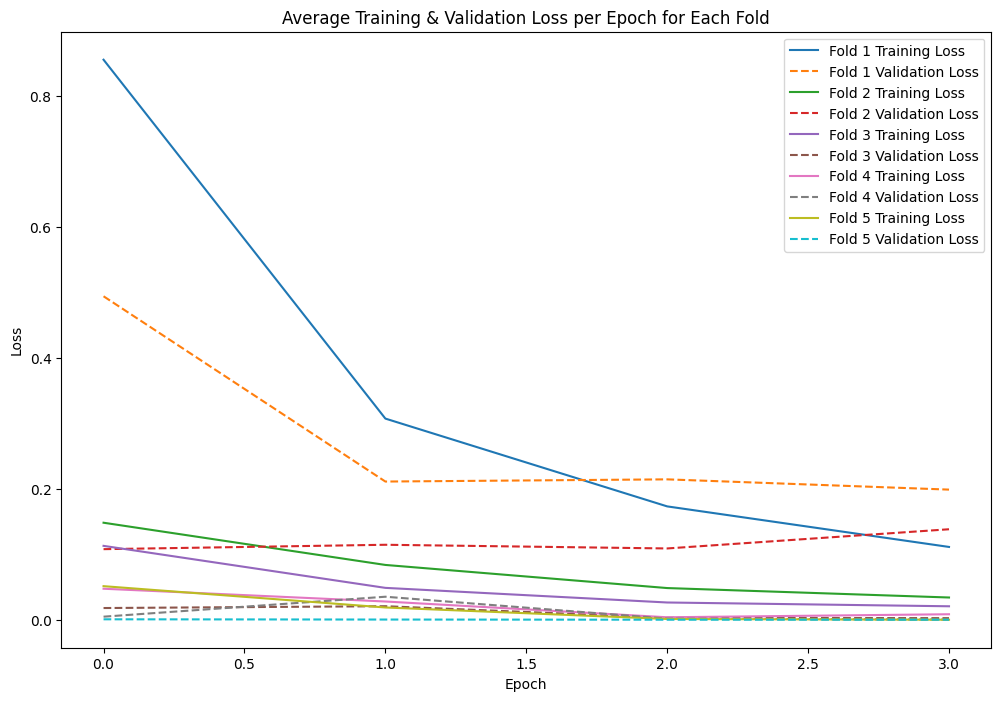

In [8]:
plt.figure(figsize=(12, 8))
for i in range(n_splits):
    plt.plot(all_folds_train_losses[i], label=f'Fold {i+1} Training Loss')
    plt.plot(all_folds_val_losses[i], label=f'Fold {i+1} Validation Loss', linestyle='--')
plt.title('Average Training & Validation Loss per Epoch for Each Fold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('avg_train_val_loss_plot.png')
plt.show()


#### Plotting Training and Validation Loss:

- **Plotting Setup:**
  - Initializes a figure with a size of 12x8 inches for the plot.

- **Plotting Loop:**
  - Iterates over each fold (`i`) to plot training and validation losses for all folds.
  - Plots training loss for the current fold with a solid line.
  - Plots validation loss for the current fold with a dashed line.

- **Plot Title and Labels:**
  - Sets the plot title to 'Average Training & Validation Loss per Epoch for Each Fold'.
  - Labels the x-axis as 'Epoch' and the y-axis as 'Loss'.

- **Legend:**
  - Adds a legend to the plot indicating which line corresponds to training or validation loss for each fold.

## Plot: Average Training and Validation Accuracy

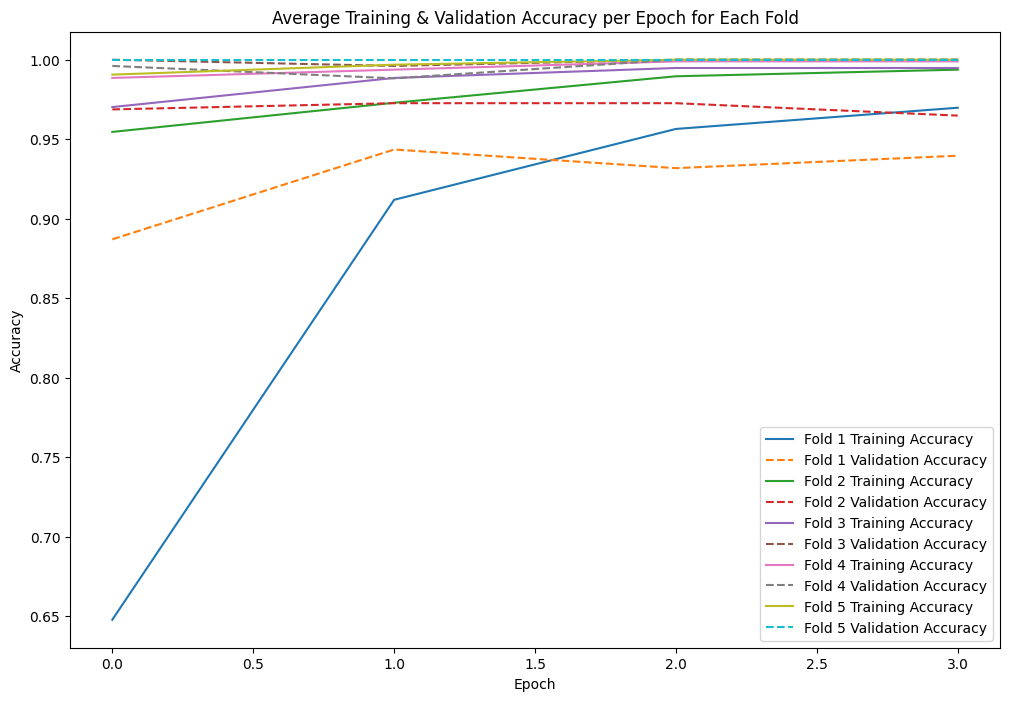

In [9]:
plt.figure(figsize=(12, 8))
for i in range(n_splits):
    plt.plot(all_folds_train_accuracies[i], label=f'Fold {i+1} Training Accuracy')
    plt.plot(all_folds_val_accuracies[i], label=f'Fold {i+1} Validation Accuracy', linestyle='--')
plt.title('Average Training & Validation Accuracy per Epoch for Each Fold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('avg_train_val_accuracy_plot.png')
plt.show()


#### Plotting Training and Validation Accuracy:

- **Plotting Setup:**
  - Initializes a figure with a size of 12x8 inches for the plot.

- **Plotting Loop:**
  - Iterates over each fold (`i`) to plot training and validation accuracies for all folds.
  - Plots training accuracy for the current fold with a solid line.
  - Plots validation accuracy for the current fold with a dashed line.

- **Plot Title and Labels:**
  - Sets the plot title to 'Average Training & Validation Accuracy per Epoch for Each Fold'.
  - Labels the x-axis as 'Epoch' and the y-axis as 'Accuracy'.

- **Legend:**
  - Adds a legend to the plot indicating which line corresponds to training or validation accuracy for each fold.

## Evaluation

### Accuracy

In [10]:
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print("Overall Average Accuracy across all folds:", overall_accuracy)
with open('overall_accuracy.txt', 'w') as f:
    f.write(str(overall_accuracy))

Overall Average Accuracy across all folds: 0.980590717299578


### Precision, Recall and F1 Score

In [11]:
import sklearn.metrics as metrics
import pickle

print(metrics.classification_report(all_true_labels, all_predictions, target_names=['Physics', 'Medicine', 'Cybersecurity']))

res = metrics.classification_report(all_true_labels, all_predictions, target_names=['Physics', 'Medicine', 'Cybersecurity'])
with open('classification_report.txt', 'w') as f:
    f.write(res)

               precision    recall  f1-score   support

      Physics       0.96      0.98      0.97       395
     Medicine       0.98      0.97      0.98       395
Cybersecurity       0.99      0.99      0.99       395

     accuracy                           0.98      1185
    macro avg       0.98      0.98      0.98      1185
 weighted avg       0.98      0.98      0.98      1185



#### Cell Explanation: This code calculates and prints a classification report for the model's predictions on the entire validation set. The report includes precision, recall, and F1 score for each class ('Physics', 'Medicine', 'Cybersecurity').

**Importing Classification Report:**

- Imports the `classification_report` function from scikit-learn, which provides a comprehensive report on precision, recall, and F1 score.


### Confusion Matrix

In [12]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix using sklearn's confusion_matrix function
cm = confusion_matrix(all_true_labels, all_predictions)

# Now manually print out the confusion matrix
print("Confusion Matrix:")
print(cm)
with open('confusion_matrix.txt', 'w') as f:
    f.write(str(cm))

Confusion Matrix:
[[386   7   2]
 [ 12 383   0]
 [  2   0 393]]


/tmp/ipykernel_788465/2429832737.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['Physics', 'Medicine', 'Cybersecurity'])
/tmp/ipykernel_788465/2429832737.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['Physics', 'Medicine', 'Cybersecurity'])


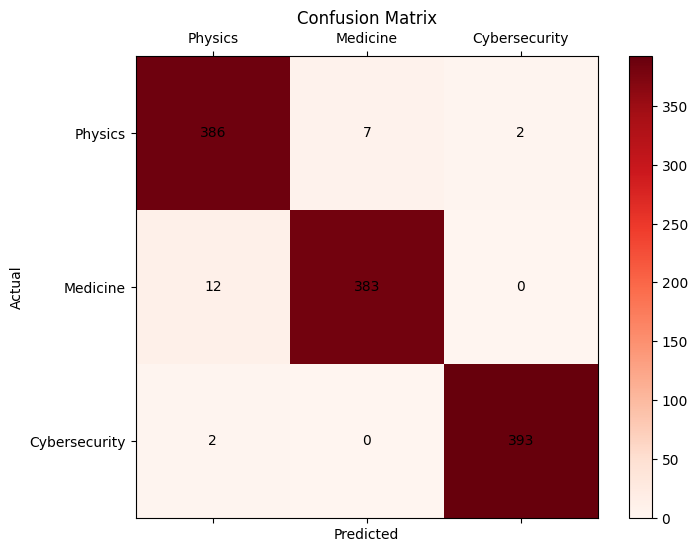

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming cm is your confusion matrix
cm = np.array([[386,  7,   2],
               [ 12, 383,   0],
               [  2,   0, 393]])

# Plotting the confusion matrix without seaborn
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='Reds')

# Adding color bar
plt.colorbar(cax)

# Adding annotations
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, val, ha='center', va='center', color='black')

# Setting axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Setting tick labels
ax.set_xticklabels([''] + ['Physics', 'Medicine', 'Cybersecurity'])
ax.set_yticklabels([''] + ['Physics', 'Medicine', 'Cybersecurity'])

plt.title('Confusion Matrix')
plt.show()

**Physics:**
- True Positives (TP): The model correctly predicted 'Physics' 386 times.
- False Positives (FP): The model incorrectly predicted 'Physics' when it was actually 'Medicine' 7 times and 'Cybersecurity' 2 times.
- False Negatives (FN): The model failed to predict 'Physics' 12 times when it was actually 'Physics' and predicted 'Medicine' instead, and 0 times when it predicted 'Cybersecurity' instead.
- True Negatives (TN): The model correctly identified 'Medicine' and 'Cybersecurity' instances that were not 'Physics'. This is calculated by excluding all the instances of the row and column for 'Physics' (the sum of all values except the first row and the first column).

**Medicine:**
- True Positives (TP): The model correctly predicted 'Medicine' 383 times.
- False Positives (FP): The model incorrectly predicted 'Medicine' 12 times when it was actually 'Physics' and 0 times when it was 'Cybersecurity'.
- False Negatives (FN): The model failed to predict 'Medicine' 7 times when it was actually 'Medicine' and predicted 'Physics' instead, and 0 times when it predicted 'Cybersecurity' instead.
- True Negatives (TN): The model correctly identified 'Physics' and 'Cybersecurity' instances that were not 'Medicine'. This is calculated by excluding all the instances of the row and column for 'Medicine'.

**Cybersecurity:**
- True Positives (TP): The model correctly predicted 'Cybersecurity' 393 times.
- False Positives (FP): The model incorrectly predicted 'Cybersecurity' 2 times when it was actually 'Physics' and 0 times when it was 'Medicine'.
- False Negatives (FN): The model failed to predict 'Cybersecurity' 2 times when it was actually 'Cybersecurity' and predicted 'Physics' instead, and 0 times when it predicted 'Medicine' instead.
- True Negatives (TN): The model correctly identified 'Physics' and 'Medicine' instances that were not 'Cybersecurity'. This is calculated by excluding all the instances of the row and column for 'Cybersecurity'.